# Learn CNN


add conv layer
add l2 regularizer
add LSTMBlockFused
try LSTMcudnn
remove dropout to add optimized graph, add quantized graph

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
import sys
sys.path.append('Codes')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from dataShaping import *
from savePerf import *
from saveTransformedGraph import optimizeGraph
import scipy.io.wavfile
import time
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import *




modelName = "CNN1"
# create directory experiment
date = time.strftime("%Y-%m-%d-%H-%M")
path = os.path.join("Experiments",date)
if not os.path.isdir(path):
    os.makedirs(path)
    #experiment/"date"/temp will contain the backuped model parameters
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
    # if you run the file two time in a minute
else :
    date = date+'(2)'
    path = os.path.join("Experiments",date)
    os.makedirs(path)
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)

# directory that will contain tensorboard information
pathLog = 'Tf_logs'
if not os.path.isdir(pathLog):
    os.makedirs(pathLog)
pathLog = "{}/run-{}/".format(pathLog,date)

version = tf.__version__
print ("version {} of tensorflow".format(version))

#############################
# Model parameters
#############################
trainTestRatio = 0.8
#if you cannot load all the data set in Ram specify wich part you want to load (0 means all the dataset)
maxSize = 0
num_step = 150                                       # time step before reduction
conv_chan = [35 , 70]                                #number of kernel for convolution
conv_strides = 35                                    #delay between two convolution
conv_size = 12                                       #filter size for the convolution
size_poll = 4
reg_scale = 0
l1l2Prop = 0.4  # 1 =>l1, 0=> l2
reg_scale_l1 = l1l2Prop*reg_scale
reg_scale_l2 = ((1-l1l2Prop)/2)*reg_scale
num_hidden = 200                                      #num of hidden units
num_class = 1                                         #size of the output
num_feature = 1                                       # size of the input
batch_size = 2500                                     # number of sequence taken before to compute the gradient
n_layer = 1                                           #num_layer

#num_hidden = num_hidden/keep_prob
num_epoch = 100000                                    # process all the datas num_epoch times
trainDuration = 60*60*10                              # or during a determined duration(second)
amplifierName = 'MesaMarkVCrunch'
fileNameTrain = 'Datasets/training'+amplifierName+'.mat'             #dataset train/test path
fileNameTest = 'Datasets/test'+amplifierName+'.mat' # dataset validation path
fileNameValidation = 'Datasets/val'+amplifierName+'.mat'

#############################
# Loading data
#############################
matrix = sio.loadmat(fileNameTrain)
matrixTrain = matrix['train']
matrix = sio.loadmat(fileNameTest)
matrixTest = matrix['test']
if maxSize ==0:
    maxSize = len(matrixTrain)
    print("maxSize = {}".format(maxSize))

train_input,train_output,test_input,test_output = loadInputOutputSeq(matrixTrain,matrixTest,num_step,maxSize)

print("shape input train {}".format(np.shape(train_input)))
numTrain = len(train_output)
print ("Data loaded")
#######################
#Graph
#######################

G = tf.Graph()
with G.as_default():
    with tf.name_scope("placeHolder"):
        data = tf.placeholder(tf.float32, [None, num_step], name ="data") #Number of examples, number of input step (time step), dimension of each input
        target = tf.placeholder(tf.float32, [None, num_class],name = "target") # batchSize, nbClass
     
    dataShaped = tf.reshape(data,[tf.shape(data)[0],num_step,1,1]) # batchSize, height,width,channel  
    dataShaped = tf.transpose(dataShaped,[0,3,1,2]) # faster on gpu btachSize,Channel,Height,width
    
    with tf.variable_scope("ConvLayers"):
        regularizerC1 = tf.contrib.layers.l1_l2_regularizer(scale_l1=reg_scale_l1,scale_l2=reg_scale_l2,scope="regC1")
        conv1 = tf.layers.conv2d(inputs = dataShaped,filters = conv_chan[0],
                                       kernel_size = (conv_size,1),strides=(3,1),
                                       padding = "same",activation=tf.nn.relu,kernel_regularizer=regularizerC1,
                                       data_format='channels_first',name="conv1")
        
        # pool1
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 1, 3, 1], strides=[1, 1, 2, 1],data_format='NCHW',padding='SAME', name='pool1')  
        regularizerC2 = tf.contrib.layers.l1_l2_regularizer(scale_l1=reg_scale_l1,scale_l2=reg_scale_l2,scope="regC2")
        conv2 = tf.layers.conv2d(inputs = pool1,filters = conv_chan[1],
                                       kernel_size = (conv_size/2,1),strides=(1,1),
                                       padding = "same",activation=tf.nn.relu,kernel_regularizer=regularizerC1,
                                       data_format='channels_first',name="conv2")
        

        # pool2
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 1, 3, 1], strides=[1, 1, 2, 1],data_format='NCHW',padding='SAME', name='pool2')
        
    # reshape pool 2 cnn to make a fully connected layer entry
    dataShape = int(np.prod(pool2.get_shape()[1:]))
    dataReshaped = tf.reshape(pool2, [-1, dataShape])
    FC1 = fully_connected(dataReshaped,1000,activation_fn=tf.nn.relu,weights_regularizer=None,scope="FC1")

    intermediate = FC1
    prediction = fully_connected(FC1,int(target.get_shape()[1]),activation_fn=tf.nn.tanh,weights_regularizer=None,scope="FCPred")

    #Compute the mean square error
    MSE = tf.reduce_mean(tf.square(prediction-target))
    EnergyTarget = tf.reduce_mean(tf.square(target)) 
    
    #get regularizer
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    MSEReg = tf.add_n([MSE]+reg_losses,name="MSEReg")
    # create optimizer
    optimizer = tf.train.AdamOptimizer()
    #Compute gradient and apply backpropagation
    minimize = optimizer.minimize(MSEReg)

    # Create summary view for tensorboard
    mse_summary = tf.summary.scalar('RMSE',tf.sqrt(MSE))
    
    summary_op = tf.summary.merge_all()
    
    #Create an init op to initialize variable
    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver() # save variable, use saver.restore(sess,"date/tmp/my_model.ckpt") instead of sess.run(init_op)

##############################
# Execution du graphe
##############################
    
with tf.Session(graph=G) as sess:
    #restorePath = os.path.join('2017-09-11-18-07','temp','my_model.ckpt') # example for restore a previous model
    #saver.restore(sess,restorePath)
    sess.run(init_op)
    train_writer = tf.summary.FileWriter(pathLog+'train',graph =tf.get_default_graph())
    test_writer = tf.summary.FileWriter(pathLog+'test')

    no_of_batches = int(np.floor((numTrain)/batch_size)) # numtrain -numstep ?
    no_of_batchesTest = int(np.floor((len(test_input))/batch_size))
    tStart = time.clock()
    epoch =0
    for epoch in range(num_epoch):
        tEpoch = time.clock()
        if (time.clock()-tStart < trainDuration):
            ptr = 0
            if epoch % 20==0 : # each ten epoch save the model
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myGraph.pb',as_text=False)
                save_path = saver.save(sess,os.path.join(pathTemp,'myModel.ckpt'))
            pMSETrain=0
            for j in range(no_of_batches):
                inp, out = train_input[ptr:ptr+batch_size],train_output[ptr:ptr+batch_size]
                ptr+=batch_size
                if j % np.floor(numTrain/len(test_input)) ==0 : # This is to have a train summary and a test summary of the same size
                    _,summary_str,pMSETrainTemp = sess.run([minimize,summary_op,MSE],{data: inp, target: out})

                    pMSETrain += pMSETrainTemp
                    step = epoch*no_of_batches+j
                    train_writer.add_summary(summary_str,step)
                else :
                    sess.run([minimize],{data: inp, target: out})
                    #[print(n.name) for n in tf.get_default_graph().as_graph_def().node]
                   
            RMSETrain = np.sqrt(pMSETrain/no_of_batchesTest)
            print ("Epoch -{} calculated in {:5.2f} s ".format(epoch,time.clock()-tEpoch))
            # evaluate the model on the test set (compute the mean of the MSE)
            pMSE = 0
            ptr2 = 0
            pEnergyTarget = 0
            for k in range(no_of_batchesTest):
                pMSETemp,pEnergyTargetTemp,summary_str = sess.run([MSE,EnergyTarget,summary_op],{data: test_input[ptr2:ptr2+batch_size] , target: test_output[ptr2:ptr2+batch_size]})
                pMSE += pMSETemp
                ptr2 += batch_size
                pEnergyTarget+=pEnergyTargetTemp
                step = epoch*no_of_batchesTest+k
                test_writer.add_summary(summary_str,step*np.floor(numTrain/len(test_input)))
            RMSETest = np.sqrt(pMSE/no_of_batchesTest)
            RMSENorm = np.sqrt(pMSE/pEnergyTarget)
            print("Epoch {} MSE {:.5}, RMSENorm: {:.5} on test set with deviation of {:.2f}%".format(epoch,RMSETest,RMSENorm,100*np.sqrt((RMSETrain-RMSETest)**2)/RMSETrain))
        else : break # break the while loop if number of epoch is reached
    tStop = time.clock()
    trainTime = time.strftime("%d:%H:%M:%S ", time.gmtime(tStop-tStart))
    
    #######################
    # Save Graph variable and information about the running session
    #######################
    # save graph model
    tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myFinalGraph.pbtxt',as_text=True)
    # Save checkpoint variables
    save_path = saver.save(sess,os.path.join(pathTemp,'myFinalModel.ckpt'))
    print ("Training duration {}".format(trainTime))
    totalParameters =np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()])
    print("Number of training variable {}".format(totalParameters))
    # log
    infoLog={}
    infoLog["path"] = path
    infoLog["MSE"] = np.sqrt(pMSE/no_of_batchesTest)
    infoLog["num_step"] = num_step
    infoLog["num_hidden"] = num_hidden
    infoLog["num_epoch"] = epoch
    infoLog["batch_size"] = batch_size
    infoLog["maxSize"] = maxSize
    infoLog["duration"] = trainTime
    infoLog["totalParameters"] = totalParameters
    infoLog["version"] = version
    infoLog["n_layer"] = n_layer
    infoLog["trainDropout"] = 0
    infoLog["nameModel"] = modelName
    infoLog["conv_chan"] = conv_chan
    infoLog["strides"] = conv_strides
    infoLog["conv_size"] = conv_size
    infoLog["amplifierName"]=amplifierName
    logPerf(infoLog)
    input_nodes=["placeHolder/data"]
    output_nodes=["FCPred/Tanh"]
    optimizeGraph(pathTemp,input_nodes,output_nodes)
    
    
                                                 
    
    ###############################
    #   validation dataset and emulate guitar signal
    ###############################
    matrixVal = sio.loadmat(fileNameValidation)
    matrixVal = matrixVal['val']  
    valSize = 0
    if valSize == 0 :
        valSize = len(matrixVal)
    # shape validation test
    val_input,val_output = loadValidationSeq(matrixVal,num_step,valSize)
    lPrediction = []
    lTarget = []
    ptr3 = 0
    no_of_batchesVal = int(np.floor((len(val_input))/batch_size))
    for k in range(no_of_batchesVal):
        pPrediction,pTarget = sess.run([prediction,target],{data: val_input[ptr3:ptr3+batch_size], target: val_output[ptr3:ptr3+batch_size]}) 
        lPrediction.append(pPrediction)
        lTarget.append(pTarget)   
        ptr3+=batch_size
    #plt.show()scree
    predictionArray = np.array(lPrediction,dtype=np.float32).ravel()
    targetArray = np.array(lTarget,dtype=np.float32).ravel()
    scipy.io.wavfile.write(os.path.join(path,'prediction.wav'),44100,predictionArray)
    scipy.io.wavfile.write(os.path.join(path,'target.wav'),44100,targetArray)

    # save emulation in a pickle format
    ax = plt.subplot(111)
    ax.plot(predictionArray[:10000],label='prediction')
    ax.plot(targetArray[:10000],label='target')
    ax.legend()
    nameFigEstimation = os.path.join(path,"targetVsPrediction.pickle")
    pickle.dump(ax,open(nameFigEstimation, 'wb'))
print ("done, good job kids")



version 1.10.1 of tensorflow
maxSize = 6726407
shape input train (6726258, 150)
Data loaded
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
Epoch -0 calculated in 24.06 s 
Epoch 0 MSE 0.14125, RMSENorm: 0.31481 on test set with deviation of 12.35%
Epoch -1 calculated in 23.15 s 
Epoch 1 MSE 0.13326, RMSENorm: 0.29699 on test set with deviation of 8.91%
Epoch -2 calculated in 23.08 s 
Epoch 2 MSE 0.13812, RMSENorm: 0.30783 on test set with deviation of 18.32%
Epoch -3 calculated in 23.20 s 
Epoch 3 MSE 0.13679, RMSENorm: 0.30488 on test set with deviation of 20.37%
Epoch -4 calculated in 23.05 s 
Epoch 4 MSE 0.12666, RMSENorm: 0.2823 on test set with deviation of 16.67%
Epoch -5 calculated in 22.98 s 
Epoch 5 MSE 0.11585, RMSENorm: 0.2582 on test set with deviation of 10.25%
Epoch -6 calculated in 23.12 s 
Epoch 6 MSE 0.11799, RMSENorm: 0.26296 on test set with deviation of 11.54%
Epoch -7 calculated in 23.13 s 
Epoch 7 MSE 0.12087, RMSE

<IPython.core.display.Javascript object>


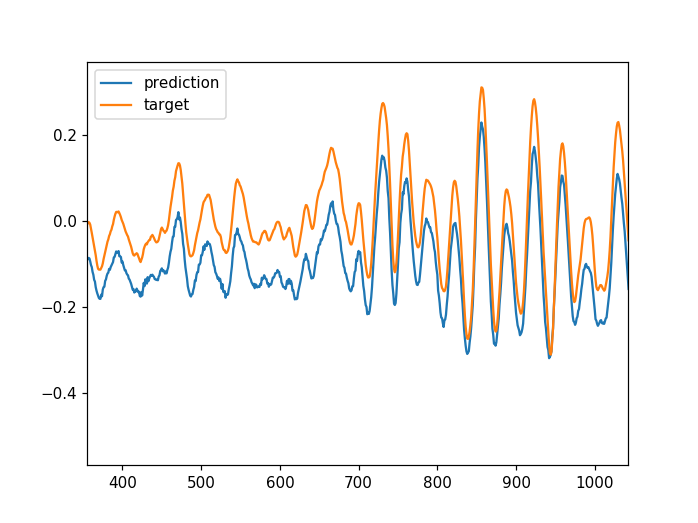

In [2]:
from show import *
%matplotlib notebook
showPickle(nameFigEstimation)